#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Differential Equations

We now consider the problem of computing $y(t)$ from an *ordinary differential equation* (ODE)

$$ y'(t) = f(t,y) $$

and initial condition $y(0)$.
In the following, $y$ may be a scalar or vector value.
For convenience of notation, we may suppress the time dependence by writing $y$ instead of $y(t)$.

### Second Order Equations

A second order system such as

$$ y'' = f(t, y, y') $$

may always be converted to a first order system by introducing a new variable

$$ \begin{bmatrix} y_0 \\ y_1 \end{bmatrix}' = \begin{bmatrix} y_1 \\ f(t, y_0, y_1) \end{bmatrix} . $$
Therefore, without loss of generality, we will focus on first order systems.

### Implicit formulations

We have chosen the explicit representation $y' = f(t,y)$, but it is more general to write $h(t,y,y') = 0$.
If $\partial h/\partial y'$ is singular, then this describes a *differential algebraic equation* (DAE).  DAE are more challenging to solve and beyond the scope of this course.

## Linear Equations

If $f(y,t)$ is a linear function of $y$ then we have a linear ODE
$$ y' = A(t) y + \text{source}(t) . $$
If $A(t)$ is independent of $t$ and $\text{source}(t) = 0$ then we have a linear, constant, autonomous ODE.

When $y$ is a scalar then $A = a$ is a scalar and the solution is
$$ y = y(0) e^{at} . $$

#### Question
What qualitative dynamics does this imply for
* $a > 0$?
* $a < 0$?
* $a$ imaginary?

#### Question
* What if $A$ is diagonal?
* What if $A = X \Lambda X^{-1}$?

#### Matrix exponential
The general solution can be written in terms of the matrix exponential.
$$ y(t) = e^{At} y(0) . $$
The matrix exponential is defined by its Taylor series
$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](http://www.cs.cornell.edu/cv/ResearchPDF/19ways+.pdf).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

## Forward Euler Method

The simplest method for solving $y'(t) = f(t,y)$ is
to use numerical differentiation to write
$$ y' \approx \frac{y(h) - y(0)}{h} $$
which yields the solution estimate
$$ \tilde y(h) = y(0) + h f(0, y(0)) $$
where $h$ is the step size.

Let's try this on a scalar problem
$$ y' = -k (y - \cos t) $$
where $k$ is a parameter controlling the rate at which the solution $u(t)$ is pulled toward the curve $\cos t$.

NOTES: Nice results so long as the product of $k$ and $h$ was small

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

def ode_euler(f, y0, tfinal=1, h=0.1):
    y = np.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        tnext = min(t+h, tfinal)
        h = tnext - t
        y += h * f(t, y)
        t = tnext
        thist.append(t)
        yhist.append(y.copy())
    return np.array(thist), np.array(yhist)

tests = []

class cosine:
    def __init__(self, k=5):
        self.k = k
    def __repr__(self):
        return 'cosine(k={:d})'.format(self.k)
    def f(self, t, y):
        return -self.k * (y - np.cos(t))
    def y(self, t, y0):
        k2p1 = self.k**2+1
        return (y0 - self.k**2/k2p1) * np.exp(-self.k*t) + self.k*(np.sin(t) + self.k*np.cos(t))/k2p1

tests.append(cosine(k=2))
tests.append(cosine(k=5))    

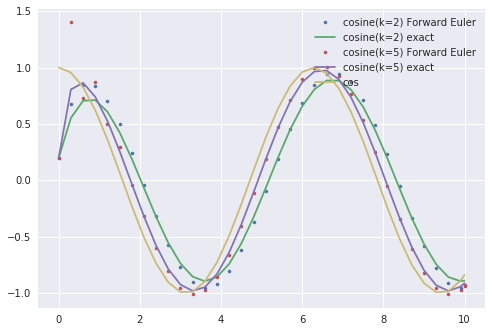

In [5]:
y0 = np.array([.2])
for test in tests:
    thist, yhist = ode_euler(test.f, y0, h=.3, tfinal=10)
    plt.plot(thist, yhist, '.', label=repr(test)+' Forward Euler')
    plt.plot(thist, test.y(thist, y0), label=repr(test)+' exact')
plt.plot(thist, np.cos(thist), label='cos')
plt.legend(loc='upper right');

NOTES: results start to blow up when timestep, $h$, gets bigger<br>
NOTES: for any given $k$(i.e. $k$ const), there is a critical value s.t. when $h$ is bigger than the critical value, it blows up

#### Question

* What happens when $h$ is increased?
* What if $k$ is increased?
* What if the final time is increased?

#### Example: Linear system

Now we consider linear systems

$$ y' = A y $$

which have an exact solution $y(t) = e^{At} y(0)$ in terms of the matrix exponential.

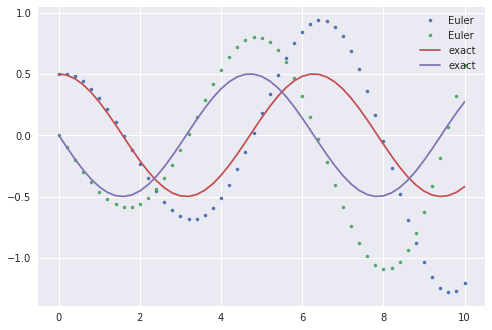

In [7]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = np.linalg.eig(A)
    return X @ np.diag(np.exp(L)) @ np.linalg.inv(X)

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, y):
        return self.A @ y
    def y(self, t, y0):
        return [np.real_if_close(expm(self.A*s) @ y0) for s in t]

test = linear(np.array([[0, 1],[-1, 0]]))
y0 = np.array([.5, 0])
thist, yhist = ode_euler(test.f, y0, h=.2, tfinal=10)
plt.figure()
plt.plot(thist, yhist, '.', label='Euler')
plt.plot(thist, test.y(thist, y0), label='exact')
plt.legend(loc='upper right');

#### Questions
* Does shrinking $h$ make this more accurate?
* What if `tfinal` is extended?
* What are the eigenvalues of $A$?

#### Runge-Kutta 4
Let's try a different method.  (We'll look back at where this comes from later.)

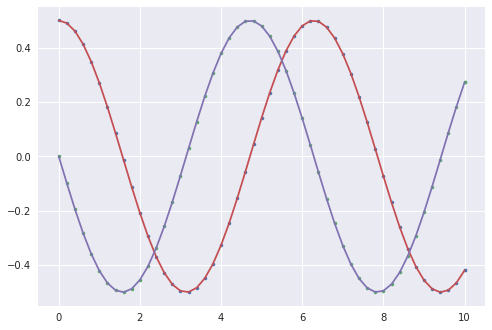

In [8]:
def ode_rk4(f, y0, tfinal=1, h=0.1):
    y = np.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        k1 = f(t, y)
        k2 = f(t+h/2, y + k1*h/2)
        k3 = f(t+h/2, y + k2*h/2)
        k4 = f(t+h, y + k3*h)
        y += h/6 * (k1 + 2*k2 + 2*k3 + k4)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return np.array(thist), np.array(yhist)

thist, yhist = ode_rk4(test.f, y0, h=.2, tfinal=10)
plt.figure()
plt.plot(thist, yhist, '.', label=repr(test)+' RK4')
plt.plot(thist, test.y(thist, y0), label=repr(test)+' exact');

### Linear Stability Analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem
$$ y' = \lambda y $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ y \to y + h \lambda y = \underbrace{(1 + h \lambda)}_{R(h \lambda)} y $$
where we have introduced the complex-valued function $R(z)$.

* When does this map cause solutions to "blow up" and when is it stable?

NOTES: note that $h\lambda = -kh$

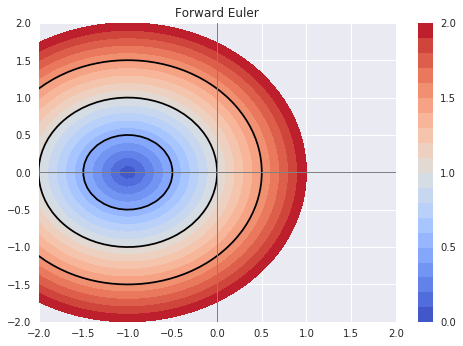

In [10]:
def plot_stability(x, y, Rz, label):
    plt.figure()
    levels = np.linspace(0, 2, 21)
    C = plt.contourf(xx, yy, np.abs(Rz), levels, cmap=plt.cm.coolwarm)
    cbar = plt.colorbar(C, ticks=np.linspace(0, 2, 5))
    plt.axvline(x=0, linewidth=1, color='grey')
    plt.axhline(y=0, linewidth=1, color='grey')
    plt.contour(xx, yy, np.abs(Rz), [.5, 1, 1.5], colors='k')
    plt.title(label)

x = np.linspace(-2,2)
xx, yy = np.meshgrid(x, x)
zz = xx + 1j*yy
R = 1 + zz #This is our stability function R(hlambda) from above
plot_stability(xx, yy, R, 'Forward Euler')

NOTES: We're only stable in the blue region<br>
NOTES: The inner blue edge is the critical value, the moment it passes that($hk$ passes critical value), then it becomes unstable

Evidently the forward Euler method is stable if $z = h\lambda$ is in the unit circle centered at $z=-1$, but not stable otherwise.

#### Implicit methods
Recall that forward Euler is the step
$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde y(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde y(h) = y(0) + h f(h, \tilde y(h)) . $$
This is a (generally) nonlinear equation for $\tilde y(h)$.
For the test equation $y' = \lambda y$, the backward Euler method is
$$ \tilde y(h) = y(0) + h \lambda \tilde y(h) $$
or
$$ \tilde y(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} y(0) . $$

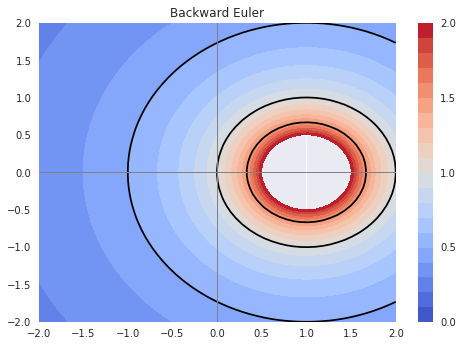

In [11]:
plot_stability(xx, yy, 1/(1-zz), 'Backward Euler')

NOTES: Hori axis is the real axis, vert axis is imaginary

Evidently backward Euler is stable in the entire left half plane (where the exact solution is also stable) and also in some significant portions of the right half plane.  Let's test it on the oscillator problem.

NOTES: One way to solve this is newton's method w/ finite differences

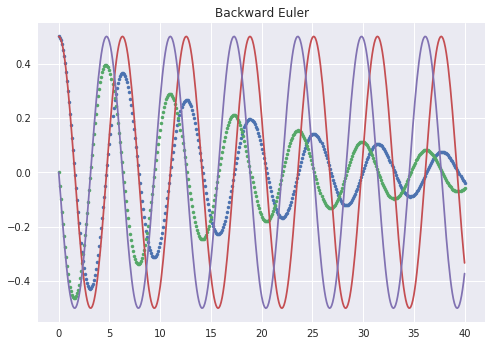

In [13]:
def solve_newtonfd(f, x0):
    def fdjacobian(x):
        J = np.eye(len(x),len(x))
        base = f(x)
        for col in J.T:
            col[:] = (f(x + 1e-8*col) - base) / 1e-8
        return J
    x = x0.copy()
    while True:
        res = f(x)
        if np.linalg.norm(res) < 1e-6: #if residual is small enough we say it has converged
            return x
        x -= np.linalg.solve(fdjacobian(x), res) # else take a newton step

def ode_beuler(f, y0, tfinal=1, h=0.1): #backward euler method
    y = np.array(y0)
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        # Solve x = y + h f(x)
        def residual(ytilde):
            #notice this formula, find it above. This is residual, we wanna find where this residual = 0
            return ytilde - (y + h * f(t+h, ytilde)) 
        y = solve_newtonfd(residual, y)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return np.array(thist), np.array(yhist)

y0 = np.array([.5, 0])
thist, yhist = ode_beuler(test.f, y0, h=.1, tfinal=40)
plt.plot(thist, yhist, '.')
plt.plot(thist, test.y(thist, y0))
plt.title('Backward Euler');

NOTES: If we set $h$ to be small, converges slower but still stable. try it!

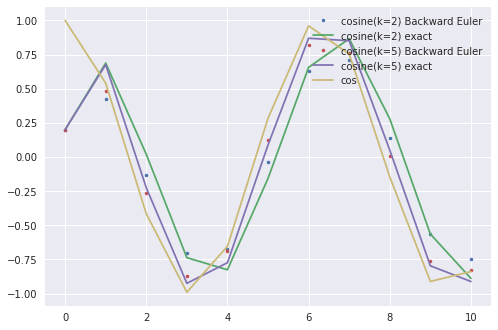

In [14]:
y0 = np.array([.2])
for tst in tests:
    thist, yhist = ode_beuler(tst.f, y0, h=1, tfinal=10)
    plt.plot(thist, yhist, '.', label=repr(tst)+' Backward Euler')
    plt.plot(thist, tst.y(thist, y0), label=repr(tst)+' exact')
plt.plot(thist, np.cos(thist), label='cos')
plt.legend(loc='upper right');

#### Observations
* We need to solve a system of equations on each time step.
* The cost to solve the linear system is $O(n^3)$ for a system of $n$ equations.
* The Jacobian matrix is $n\times n$, so requires $n^2$ storage when everything else requires $O(n)$.
* I used finite differencing to compute the Jacobian, but many problems have efficient ways to compute an exact Jacobian (it just takes some programming).
* Backward Euler is stable (as predicted by theory), but not very accurate.
* What happens when you make the time step smaller or larger?

NOTES: This part talks about the cost, when $n$ gets large it gets REALLY expensive<br>
NOTES: Although expensive, it is stable.<br>
NOTES: If you have a big timestep, as long as the eigenvalue is real positive, will still be stable


### Midpoint Method

What if instead of evaluating the function at the end of the time step, we evaluated in the middle of the time step using the average of the endpoint values.  After all, something similar improved accuracy for our numerical integration...

$$ \tilde y(h) = y(0) + h f\left(\frac h 2, \frac{\tilde y(h) + y(0)}{2} \right) $$

NOTES: 2nd argument is the average of the beginning and end. i.e. the midpoint.<br>

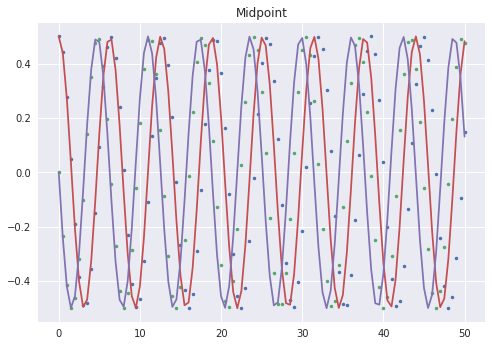

In [16]:
def ode_midpoint(f, y0, tfinal=1, h=0.1):
    y = y0.copy()
    t = 0
    thist = [t]
    yhist = [y0]
    while t < tfinal:
        h = min(h, tfinal - t)
        # Solve x = y + h f(x)
        def residual(x):
            return x - h * f(t+h/2, (x + y)/2) - y
        y = solve_newtonfd(residual, y)
        t += h
        thist.append(t)
        yhist.append(y.copy())
    return np.array(thist), np.array(yhist)

test = linear(np.array([[0, 1],[-1, 0]]))
y0 = np.array([.5,0])
thist, yhist = ode_midpoint(test.f, y0, h=.5, tfinal=50)
plt.plot(thist, yhist, '.')
plt.plot(thist, test.y(thist, y0))
plt.title('Midpoint');

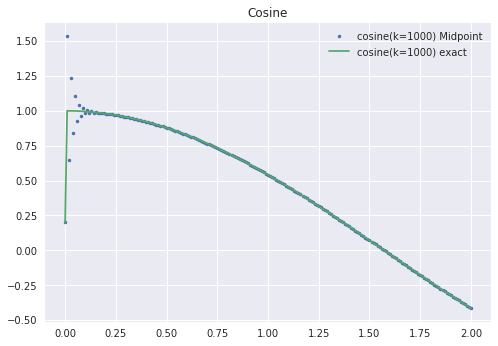

In [22]:
y0 = np.array([.2])
for test in [cosine(k=1000)]:
    thist, yhist = ode_midpoint(test.f, y0, h=.01, tfinal=2)
    #thist, yhist = ode_rk4(test.f, y0, h=.001, tfinal=2)
    #thist, yhist = ode_beuler(test.f, y0, h=.001, tfinal=2)
    plt.plot(thist, yhist, '.', label=repr(test)+' Midpoint')
    plt.plot(thist, test.y(thist, y0), label=repr(test)+' exact')
plt.legend(loc='upper right')
plt.title('Cosine');

NOTES: Try out the different commented methods and play around with `h` and `tfinal` to see what's going on<br>
NOTES: How close the dots are to the line tell you how stable/accurate the method is.

#### Observations/Questions

* This appears to be quite accurate.
* We still have to solve a system of equations on each time step.
* What happens when the step size changes?
* What is the stability function $R(z)$ for the midpoint rule?

### Stability function

When applied to the test problem $y' = \lambda y$, the midpoint method is
\begin{align}
\tilde y(h) &= y(0) + h \lambda \frac{\tilde y(h) + y(0)}{2} \\
(1 - h \lambda/2) y(h) &= (1 + h\lambda/2) y(0) \\
y(h) &= \underbrace{\frac{1 + h\lambda/2}{1 - h \lambda/2}}_{R(h \lambda} y(0)
\end{align}
so the stability function is
$$ R(z) = \frac{1 + z/2}{1 - z/2} .$$

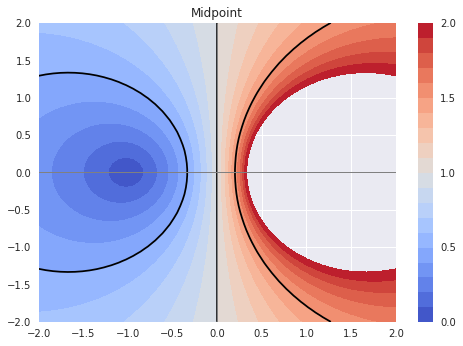

In [20]:
plot_stability(xx, yy, (1+zz)/(1-zz), 'Midpoint')

### Runge-Kutta Methods

All of the methods we have seen thus far can be represented as Runge-Kutta methods, which can be arranged as a series of $s$ "stage" equations (possibly coupled) and a completion formula.

$$\begin{split}
Y_i = y(0) + h \sum_j a_{ij} f(t+c_j h, Y_j) \\
y(h) = y(0) + h \sum_j b_j f(t+c_j h, Y_j)
\end{split}$$

where $c$ is a vector of *abscissa*, $A$ is a table of coefficients, and $b$ is a vector of completion weights.
These coefficients are typically expressed in a Butcher Table
$$ \left[ \begin{array}{c|cc}
c_0 & a_{00} & a_{01} \\
c_1 & a_{10} & a_{11} \\
\hline
& b_0 & b_1
\end{array} \right] . $$

If the matrix $A$ is strictly lower triangular, then the method is **explicit** (does not require solving equations).  We have seen forward Euler

$$ \left[ \begin{array}{c|c}
0 & 0 \\
\hline
& 1
\end{array} \right] ,$$
backward Euler
$$ \left[ \begin{array}{c|c}
1 & 1 \\
\hline
& 1
\end{array} \right] ,$$
and Midpoint
$$ \left[ \begin{array}{c|c}
\frac 1 2 & \frac 1 2 \\
\hline
& 1
\end{array} \right], $$
and that explicit method we called RK4
$$ \left[ \begin{array}{c|cccc}
0 & 0 & 0 & 0 & 0 \\
\frac 1 2 & \frac 1 2 & 0 & 0 & 0 \\
\frac 1 2 & 0 & \frac 1 2 & 0 & 0 \\
1 & 0 & 0 & 1 & 0 \\
\hline
& \frac 1 6 & \frac 1 3 & \frac 1 3 & \frac 1 6
\end{array} \right] . $$

NOTES: 1st matrix, the $c$s tell us what time, the $b$s tell the solution<br>
NOTES: 2nd matrix, at the start $0$ ($c$), we don't have to evaluate anything $0$ ($a$), and get $1$ ($b$)

In [ ]:
def Rstability(A, b, z):
    s = len(b)
    def R(z):
        return 1 + z * (b @ np.linalg.solve(np.eye(s) - z*A, np.ones(s)))
    f = np.vectorize(R)
    return f(z)

def plot_rkstability(A, b, name):
    x = np.linspace(-4,4)
    xx, yy = np.meshgrid(x, x)
    zz = xx + 1j*yy
    R = Rstability(A, b, zz)
    plot_stability(xx, yy, R, name)
    
A_rk4 = np.array([[0,0,0,0],
                    [.5,0,0,0],
                    [0,.5,0,0],
                    [0,0,1,0]])
b_rk4 = np.array([1/6, 1/3, 1/3, 1/6])

plot_rkstability(A_rk4, b_rk4, 'RK4')

In [ ]:
plot_rkstability(np.eye(1)/2, [1], 'RK Midpoint')

## Ballistics

The velocity of a particle in the $x$-$z$ plane is the time derivative of its position,
$$ \begin{bmatrix} v_x \\ v_z \end{bmatrix} = \begin{bmatrix} p_x \\ p_z \end{bmatrix}' . $$
The acceleration (derivative of velocity) depends on the force applied,
$$ \begin{bmatrix} v_x \\ v_z \end{bmatrix}' = \frac 1 m \begin{bmatrix} F_x \\ F_z \end{bmatrix} $$
where $m$ is the mass of the particle.
The gravitational force is
$$ \mathbf F^{\text{grav}} = m \begin{bmatrix} 0 \\ -g \end{bmatrix} $$
where $g = 9.8\ \text{meter}/\text{second}^2 $.
The drag force is often approximated as
$$ F^{\text{drag}} = \frac 1 2 \rho v^2 c_d A $$
where $\rho$ is the density of the fluid (assume $1\ \text{kilogram}/\text{meter}^3$),
$v =\sqrt{v_x^2  + v_z^2}$ is the velocity, $c_d$ is the drag coefficient (assume 0.2 for this projectile), and $A = \pi r^2$  is the cross-sectional area of the projectile (assume the radius is $r = .05\ \text{meter}$).
The direction of the drag force is opposite the velocity, thus the vector drag is
$$ \mathbf F^{\text{drag}}(v_x, v_z) = - \frac{\pi}{2} v c_d r^2 \begin{bmatrix} v_x \\ v_z \end{bmatrix} . $$
This produces the system of equations

$$ \begin{bmatrix} p_x \\ p_z \\ v_x \\ v_z \end{bmatrix}' =
\begin{bmatrix} v_x \\ v_z \\ \frac 1 m F_x^{\text{drag}}  \\ \frac 1 m F_z^{\text{drag}} - 9.8 \end{bmatrix} . $$

For the ballistics computation, you should solve this differential equation with an $m=8$ kilogram projectile and initial condition of a velocity  $v_0 = 300\ \text{meter}/\text{second}$ at angle $\theta$ above the horizontal, i.e.,
$$ \begin{bmatrix} 0 \\ 0 \\ v_0 \cos \theta \\ v_0 \sin \theta \end{bmatrix} . $$

The homework question is to compute the angle needed to hit a target on a distant slope of angle $\phi = 40^\circ = 40 \pi / 180$.  For that, you should adapt one of the ODE solvers to determine where the projectile crosses the plane of the target slope and adjust the angle (either by hand or using a rootfinder) to hit the target.  Don't aim too high or your explosive will detonate on the other side of the mountain!  Make sure you use a time step that you are confident is accurate enough.

![Ballistics diagram](figures/Ballistics.png)

Your code should print the angle $\theta$ and the time at which your projectile hits the slope.

### Chemical reactions

The [Oregonator](http://www.scholarpedia.org/article/Oregonator) mechanism in chemical kinetics describes an oscillatory chemical system.  It consists of three species with concentrations $\mathbf x = [x_0,x_1,x_2]^T$ (scaled units) and the evolution equations
$$ \mathbf {x'} = \begin{bmatrix} 77.27 \big(x_1 + x_0 (1 - 8.375\cdot 10^{-6} x_0 - x_1) \big) \\
                    \frac{1}{77.27} \big(x_2 - (1 + x_0) x_1 \big) \\
                    0.161 (x_0 - x_2)
                    \end{bmatrix} . $$
Starting with the initial conditions $\mathbf x_0 = [1, 2, 3]^T$, this produces the time evolution below.
![Oregonator time evolution](figures/oregonator.png)
This calculation was performed using 287 steps of an adaptive implicit time integrator, where the time step size was adapted to preserve accuracy.  The time step size in shown in the first panel and the other three are the evolution of concentrations over time.

#### 1. How to measure accuracy?

A differential equation solver produces a time history of chemical concentrations
$$ x(t), \quad 0 \le t \le T_{\text{final}} .$$
We would like a measure of accuracy that does not explicitly depend on the solver or time steps that are used.  If a different method produces the evolution $\tilde x(t)$, then we would like to be able to measure the difference as
$$ \lVert \phi(\tilde x) - \phi(x) \rVert . $$
The function $\phi(\cdot)$ could return the solution at a particular time, it could measure the time between key events, or could be something else.
Choose a metric and explain why you chose it.

#### 2. Implicit versus Explicit

Is an implicit method better than an explicit method for solving the Oregonator?
Solve the Oregonator problem using an explicit method and using an implicit method (you can adapt code from the notebook or implement a method that is not in the notebook).
The Oregonator system has no known analytic solution, so you'll have to numerically compute a reference solution.
Do this using a method you believe to be highly accurate and explain why you believe it is very accurate.
(A common justification would be to refine the time step and compare using the metric $\phi$ above.)

Different methods (implicit versus explicit, Euler versus RK4, etc.) have different costs per time step.  Choose a way to measure cost and explain your choice and any shortcomings that it may have.

Compare the cost (using the metric you chose above) and accuracy (using $\phi$) of the implicit method to the cost and accuracy of the explicit method.  (This is often plotted as *accuracy versus cost* with a log-log scale.)  Explain what factors might go into your decision.

#### 3. Eigenvalues

Calculate the eigenvalues of the Jacobian matrix at different times.  (You can compute it analytically or using the `fdjacobian` code in this notebook.)  Do you notice any qualitative differences?  For example, are there any times when there are eigenvalues with positive real part?

#### 4. Generalization

Realistic chemical mechanisms can have hundreds or thousands of species (the Oregonator has only three).  Explain how the choice of methods might change when solving a large reaction mechanism.